# Placement test on a map using a bayesian network

We consider a map that consists of $H$ capsules. Capsule $i$ contains $N_i$ questions on a given subject, totaling $N = \sum_{i=1}^H N_i$ questions.
Our goal is to find out the student's ability on each capsule, $\theta_i$ by asking as few questions as possible.

The students are asked a series of questions from all questions in an order that allows to determine $\theta = (\theta_1, \ldots, \theta_H)$. The $n$th question asked is question $j_n$ from capsule $i_n$, and we denote $k_n = (i_n, j_n)$.
We denote $R_n$ the list of questions that have not been asked yet after the $n$th question.

## Global imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.special import expit, logit

from pymc import \
    Model, MAP, MCMC, \
    Bernoulli, Lambda, Logistic, \
    geweke, raftery_lewis
from pymc.graph import dag, graph, moral_graph
from pymc.Matplot import geweke_plot, summary_plot

from IPython.display import Image, display

from igraph import Graph
from igraph.drawing import plot as igraph_plot

## Description of the model

The model is described by the following random variables:
- $\Theta_i$ are binary variables indicating whether the student masters capsule $i$ ($i \in \{1, \ldots, H\}$).
- $U_{i,j}$ are binary variables indicating whether the student answers correctly question $j$ of capsule $i$ ($i \in \{1, \ldots, H\}, j \in \{1, \ldots, N_i\}$).

We denote $p_{i,j}(\theta_i) = P(U_{i,j} = 1 | \Theta_i = \theta_i)$ the probability of answering correctly the question $j$ of capsule $i$ depending on the student's ability on the capsule $\theta_i \in \{0; 1\}$, defined by the following model:
$$p_{i,j}(\theta_i) = (1 - \theta_i)\cdot p_{i,j}^0 + \theta_i \cdot p_{i,j}^1, \forall i \in \{1, \ldots, H\}, \forall j \in \{1, \ldots, N_i\}$$
We use this model instead of the IRT in order to keep $\theta$ discrete.

The parameters $p_{i,j}^k, k \in \{0,1\}$ will be updated after each user's placement test.

We call $C_i$ the set of parents of capsule $i$ and define the depth of a capsule ad $\Delta_i = 1$ if $C_i = \emptyset$, $\Delta_i = 1 + \max_{j \in C_i} \Delta_j$ otherwise.

We assume the following relationships between capsule masteries:
$$P(\Theta_i = 1 | C_i) = \frac{1}{2} - \frac{1 - \bar\theta_{C_i}}{1 + \Delta_i}$$
where
$$\bar\theta_{C_i} = \frac{1}{\# C_i} \sum_{j \in C_i} \theta_j$$

We define below the functions to compute the probability of answering a question correctly, the probability of mastering a capsule given the mastery of its parents, and the partial Fisher information for a question.

In [3]:
def p_ij(theta_i, p0=0.0, p1=1.0):
    return (1 - theta_i) * p0 + theta_i * p1

def p_theta_parents(Theta_C, depth):
    if not Theta_C:
        return 1./2.
    return 1./2. - (1 - np.mean(Theta_C)) / float(1 + depth)

The following function creates a PyMC model given a map graph, the $p_{i,j}^k$ and the evidence, _i.e._ the observed $U_{i,j}$ (which may be `None` if they are not observed).

In [4]:
def create_map_model(map_graph, p0, p1, evidence):

    model_nodes = {}

    visited_nodes = set()
    unvisited_nodes = set(map_graph.vs)
    while unvisited_nodes:
        for v in set(unvisited_nodes):
            parents = set(map_graph.vs[i] for i in map_graph.neighbors(v, mode="IN"))
            if parents:
                if parents <= visited_nodes:
                    v["depth"] = np.amax([parent["depth"] for parent in parents]) + 1
                    Theta_C = [model_nodes["Theta_%s" % parent["name"]] for parent in parents]
                    model_nodes["p_theta%s" % v["name"]] = Lambda(
                        "p_theta%s" % v["name"],
                        lambda Theta_C=Theta_C: p_theta_parents(Theta_C, v["depth"])
                    )
                    model_nodes["Theta_%s" % v["name"]] = Bernoulli(
                        "Theta_%s" % v["name"],
                         p=model_nodes["p_theta%s" % v["name"]]
                    )
                    visited_nodes.add(v)
                    unvisited_nodes.remove(v)
            else:
                v["depth"] = 1
                model_nodes["Theta_%s" % v["name"]] = Bernoulli(
                    "Theta_%s" % v["name"],
                    p=1./2.
                )
                visited_nodes.add(v)
                unvisited_nodes.remove(v)
            print v["name"]

    for i, questions in enumerate(p0):
        for j, p0_ij in enumerate(questions):
            Theta = model_nodes["Theta_%d" % (i+1)]
            p_index = "p_%d_%d" % (i+1, j+1)
            model_nodes[p_index] = Lambda(
                p_index,
                lambda Theta=Theta: p_ij(Theta, p0_ij, p1[i][j])
            )
            U_index = "U_%d_%d" % (i+1, j+1)
            model_nodes[U_index] = Bernoulli(
                U_index,
                p=model_nodes[p_index],
                observed=evidence[i][j] is not None,
                value=evidence[i][j]
            )

    return Model(model_nodes.values())

In [14]:
%load_ext fortranmagic

/home/enguerand/.virtualenvs/gryzz-lab/local/lib/python2.7/site-packages/IPython/utils/path.py:265: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [5]:
def sample_model(model, start_with_map=True, **kwargs):
    if start_with_map:
        M_map = MAP(model)
        M_map.fit()
    M = MCMC(model)
    kwargs.setdefault("iter", 10000)
    kwargs.setdefault("burn", 1000)
    kwargs.setdefault("thin", 2)
    M.sample(**kwargs)
    return M

In [6]:
def marginal_probabilities(mcmc_result):
    """Return estimators for marginal probabilities knowing some set of evidences
    :param mcmc_result: An object of class pymc.MCMC
    :return: a dictionary where each key is the marginal probability that the node is True knowing some set of evidence """
    dict_mean = {}
    for key, value in mcmc_result.stats().iteritems():
        dict_mean[key] = value['mean']
    return dict_mean

def result_data_frame(mcmc_result):
    """
    Concatenate every sampled Random Variables with computed probabilities.
    :param mcmc_result: An object of class pymc.MCMC
    :return: a dataframe containing every sampled Random Variables.
    """
    trace_matrix = {}
    for name in mcmc_result.stats().keys():
        trace_matrix[name] = mcmc_result.trace(name)[:]
    return pd.DataFrame.from_dict(trace_matrix)

def query_prob(mcmc_result, a, b, value):
    """
    Compute the probabilities of succeeding at question or capsule a knowing that you succeeded another capsule or question.
    :param a: Query parameter : What you want to know
    :param b: Information parameter : With what information
    :value: Value of parameter b : True or False
    :param mcmc_result: Result of the MCMC procedure
    :return: P(a|b = value)
    """
    df = result_data_frame(mcmc_result)
    b_values = (df[b] == value)
    a_values = (df[a] == True)
    return float(df[b_values & a_values].shape[0]) / df[b_values].shape[0]

def query_prob_post_p_ii(mcmc_result, H, N):
    """
    Compute every a posteriori probabilities for questions, knowing the outcome for parent capsule
    :param mcmc_result: Result of the MCMC procedure
    :evidences: A list containing for each question whether the answer has already been answered or not
    :H: Number of capsules
    :N: List of number of questions for each capsule
    :result: A tuple containing the probability of answering correctly 
    knowing that the capsule is not mastered 
    and the probability of answering correctly
    knowing that the capsule is mastered.
    If one question is already answered it will return -1e100 in order to make fisher info as small as possible.
    """
    p_0 = []
    p_1 = []
    for i in range(H):
        capsule = "Theta_%d" % (i+1)
        p_0i = []
        p_1i = []
        for j in range(N[i]):
            p_0i.append(query_prob(mcmc_result, "U_%d%d" % (i+1, j+1), capsule, False))
            p_1i.append(query_prob(mcmc_result, "U_%d%d" % (i+1, j+1), capsule, True))
        p_0.append(p_0i)
        p_1.append(p_1i)
    return p_0, p_1

## Finding the best question to ask

When the evidence contains $n-1$ questions, the $n$th question to ask, $k_n$, is determined by the following rule:
$$k_n = \arg \max_{k \in R_n} \left( \int I_{U_k}(\theta) \cdot g(\theta|u_{k_1}, \ldots, u_{k_{n-1}}) \,\mathrm{d}\theta \right)$$
where $I_{U_k}$ is the partial Fisher information from question $k$:
$$I_{U_k}(\theta) = \frac{p'_k(\theta)^2}{p_k(\theta) \cdot (1 - p_k(\theta))}$$

In our new framework, $\theta$ is binary, so this integral becomes much simpler :
$$k_n = \arg \max_{k \in R_n} \left( I_{U_k}(0) \cdot P(\theta = 0|u_{k_1}, \ldots, u_{k_{n-1}}) + I_{U_k}(1) \cdot P(\theta = 1|u_{k_1}, \ldots, u_{k_{n-1}}) \right)$$

In [7]:
def partial_fisher_info_linear(theta_i, p0=0.0, p1=1.0):
    p = p_ij(theta_i, p0, p1)
    dp = p1 - p0
    return (dp ** 2) / (p * (1 - p))

def compute_fisher_criterion(p0, p1, mcmc_result):
    """
    For each question in the pool compute the fisher criterion as defined above
    :param p_0: the set of a posteriori probabilities of answering correctly to each question,
    knowing a set of evidence (previous answers) and that the parent capsule is mastered.
    :param p_1: the set of a posteriori probabilities of answering correctly to each question,
    knowing a set of evidence (previous answers) and that the parent capsule is not mastered
    :mcmc_result: Result of the MCMC procedure
    """
    list_fisher = []
    dict_mean = marginal_probabilities(mcmc_result)
    def fisher_criterion(i, j):
        fish0 = partial_fisher_info_linear(0., p0[i][j], p1[i][j])
        fish1 = partial_fisher_info_linear(1., p0[i][j], p1[i][j])
        proba = dict_mean["Theta_%d" % (i+1)]
        return fish1 * proba + fish0 * (1 - proba)
    
    return [
        [fisher_criterion(i, j) for j, p0ij in enumerate(p0i)]
        for i, p0i in enumerate(p0)
    ]

def compute_standardized_fisher_criterion(p0, p1, mcmc_result):
    list_fisher_raw = compute_fisher_criterion(p0, p1, mcmc_result)
    return [
        (capsule_fisher - np.mean(capsule_fisher))
        for capsule_fisher in list_fisher_raw
    ]

def find_next_question(p0, p1, mcmc_result, evidence):
    list_fisher = compute_fisher_criterion(p0, p1, mcmc_result)
    for i, capsule_evidence in enumerate(evidence):
        for j, question_evidence in enumerate(capsule_evidence):
            if question_evidence is not None:
                list_fisher[i][j] = None
    capsules_max_fisher = [
        np.amax(capsule_fisher) for capsule_fisher in list_fisher
    ]
    i_max = np.argmax(capsules_max_fisher)
    j_max = np.argmax(list_fisher[i_max])
    return i_max, j_max

## Example

We consider a map with 4 capsules. Each capsule contains one question except for capsule 1 which contains two questions.

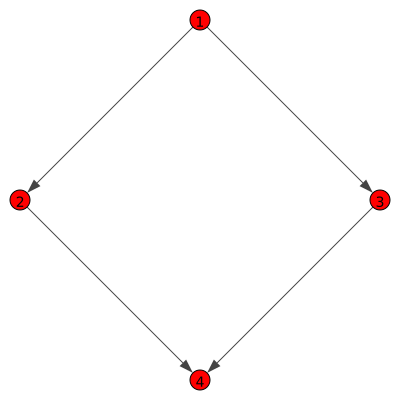

In [8]:
def create_map_graph(edges_list):
    map_graph = Graph(edges_list, directed=True)
    map_graph.vs["label"] = map_graph.vs["name"] = [str(i+1) for i, v in enumerate(map_graph.vs)]
    return map_graph

def plot_map_graph(map_graph):
    layout = map_graph.layout_sugiyama()
    return igraph_plot(map_graph, bbox=(400, 400), layout=layout)
    
map_graph = create_map_graph([(0, 1), (0, 2), (1, 3), (2, 3)])
plot_map_graph(map_graph)

We set each question's parameters, _i.e._ the probability of answering them correctly depending on whether the student masters the capsule, and the observed values.

In [9]:
p0 = [[0.50, 0.20], [0.10], [0.10], [0.15]]
p1 = [[0.70, 0.50], [0.70], [0.30], [0.20]]
evidence = [[None, 0.], [1.], [None], [None]]

We then create the PyMC model for this map.

1
2
3
4


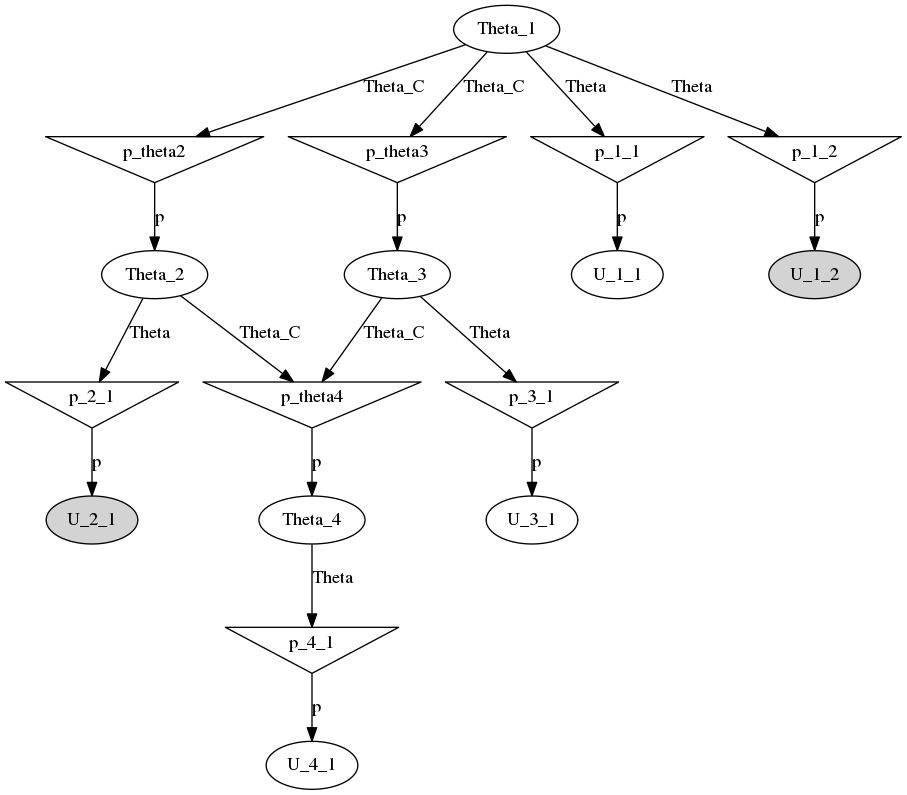

In [10]:
model = create_map_model(map_graph, p0, p1, evidence)
model_graph = dag(model)
Image(model_graph.create_png())

Let's run the model:

In [11]:
M = sample_model(model, start_with_map=False)
result_data_frame(M).mean()

 [-----------------100%-----------------] 10000 of 10000 complete in 6.2 sec

Theta_1     0.514333
Theta_2     0.443000
Theta_3     0.382333
Theta_4     0.352444
U_1_1       0.173444
U_3_1       0.167222
U_4_1       0.168111
p_1_1       0.175717
p_1_2       0.175717
p_2_1       0.172150
p_3_1       0.169117
p_4_1       0.167622
p_theta2    0.378583
p_theta3    0.378583
p_theta4    0.353167
dtype: float64

To determine whether the model converged, we will use [Geweke (1992)](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=2273AE0E7F4C500E178B9663E402EE42?doi=10.1.1.27.2952&rep=rep1&type=pdf)'s z-score.
What we are seeking is for all the points represented to be inside the confidence interval (blue and green lines).
In our example the following plot shows that the model have converged, each parameter ae close to their a posteriori value.

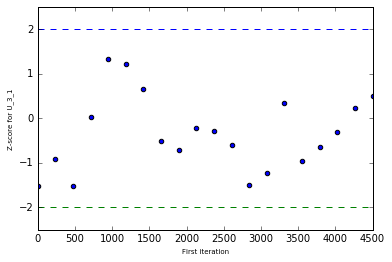

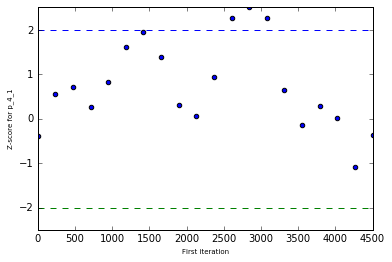

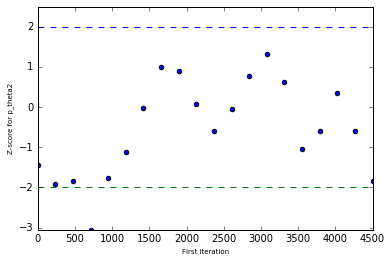

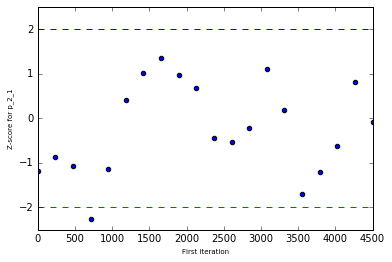

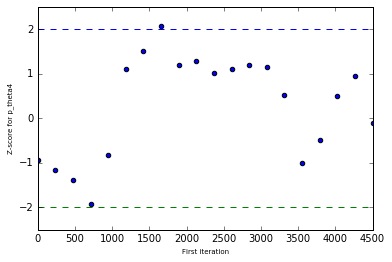

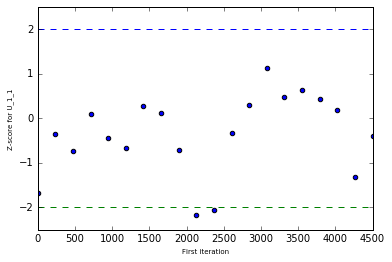

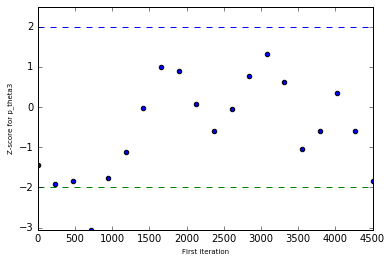

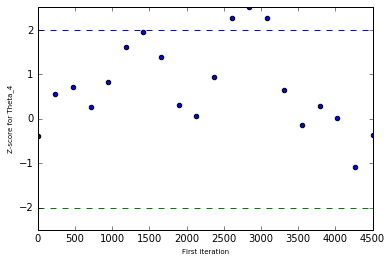

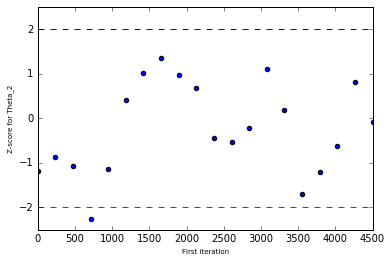

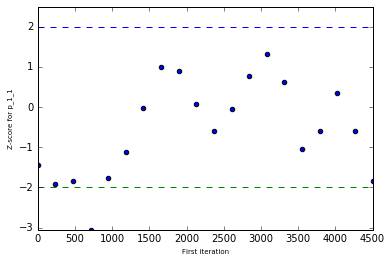

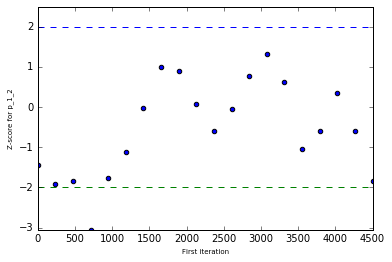

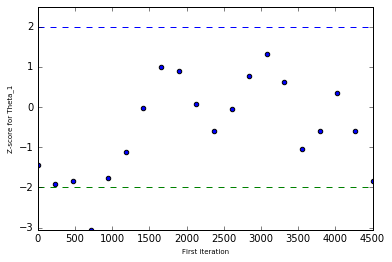

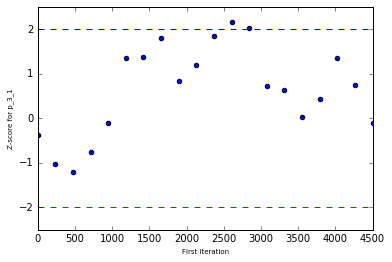

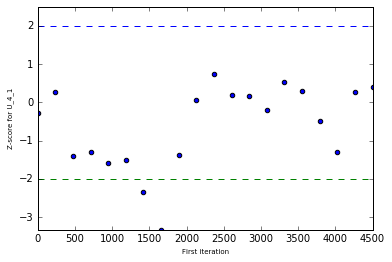

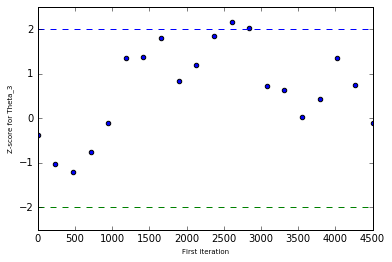

In [12]:
G = geweke(M, intervals=20)
geweke_plot(G)

We can now determine the best question to ask:

In [13]:
find_next_question(p0, p1, M, evidence)

(2, 0)

# Complete algorithm on simulated data

## The Positioning Test Algorithm

Choose a map by running one of the three cells below.

In [14]:
edges_list = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3)
]
N = [3, 3, 3, 3] # Number of questions in each capsule

In [15]:
edges_list = [
    (0, 1),
    (1, 2),
    (1, 3),
    (2, 4),
    (3, 4),
    (4, 5),
    (5, 6)
]
N = [7, 5, 6, 5, 6, 6, 5] # Number of questions in each capsule

In [11]:
edges_list = [
    (0, 2),
    (0, 3),
    (0, 4),
    (0, 5),
    (5, 8),
    (1, 8),
    (2, 6),
    (3, 6),
    (3, 7),
    (4, 7),
    (6, 10),
    (8, 9),
    (9, 10)
]
N = [7, 6, 5, 7, 8, 9, 8, 7, 6, 5, 9] # Number of questions in each capsule

Preview the graph:

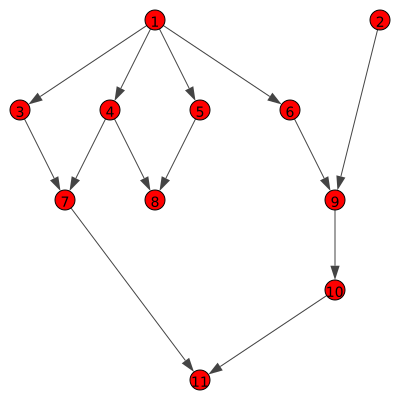

In [12]:
map_graph = create_map_graph(edges_list)
plot_map_graph(map_graph)

Choose random $p_{i,j}^k$ and instantiate empty evidence. Randomly determine the student's real ability on each capsule.

In [13]:
p1 = [np.random.uniform(low=0.5, high=1.0, size=Ni) for Ni in N]
p0 = [np.random.uniform(low=0.0, high=p1[i], size=Ni) for i, Ni in enumerate(N)]
evidence = [[None for _ in range(Ni)] for Ni in N]
capsule_abilities = np.random.binomial(n=1, p=.5, size=len(N))

Find out the best question to ask, get the student's answer, write the evidence and start again until all questions are answered:

In [14]:
def test_is_incomplete(evidence):
    for capsule_evidence in evidence:
        for question_evidence in capsule_evidence:
            if question_evidence is None:
                return True
    return False

while test_is_incomplete(evidence):
    model = create_map_model(map_graph, p0, p1, evidence)
    M = sample_model(model, start_with_map=True, burn=50, iter=1000, thin = 1)

    i, j = find_next_question(p0, p1, M, evidence)
    print "Next: capsule %d, question %d" % (i + 1, j + 1)
    capsule_ability = capsule_abilities[i]
    question_proba = p1[i][j] if capsule_ability == 1 else p0[i][j]
    evidence[i][j] = np.random.binomial(n=1, p=question_proba)
    fisher_crit = compute_standardized_fisher_criterion(p0, p1, M)[i][j]
    if fisher_crit < 0:
        break

2
1
4
3
6
5
8
7
10
9
11
10
11
 [-----------------100%-----------------] 1000 of 1000 complete in 2.9 secNext: capsule 3, question 2
2
1
4
3
6
5
8
7
10
9
11
10
11
 [-----------------100%-----------------] 1000 of 1000 complete in 3.0 secNext: capsule 8, question 4
2
1
4
3
6
5
8
7
10
9
11
10
11


KeyboardInterrupt: 

In [35]:
compute_standardized_fisher_criterion(p0,p1,M)

[array([ 10.03679339,  -4.45228465,  -2.81946181,   7.11249597,
         -1.6538867 ,  -3.69618727,  -4.52746894]),
 array([ 1.24197651, -1.39044919,  1.23298947, -1.090979  , -1.30941226,
         1.31587447]),
 array([ 0.06423091, -0.90407448, -0.58268824,  2.22539446, -0.80286266]),
 array([  0.47424713,  -4.7717162 ,  -6.26006236,  -6.29852791,
         -5.14311424,  -4.40099528,  26.40016885]),
 array([-2.86858706, -0.07550047,  6.66434251, -2.90729399, -2.37055159,
         2.63977378, -2.79296325,  1.71078006]),
 array([ -24.24905245,  -25.90070715,  -24.44272312,  -25.65532245,
         -25.76441738,  -23.35039037,  -25.96940258,  -22.07410968,
         197.40612518]),
 array([-1.4260804 , -0.85145261, -1.55694977, -1.49159492, -0.17893611,
         7.05136705,  0.02653908, -1.57289231]),
 array([-1.01712324,  3.05208794, -0.43838369, -1.01575628, -0.254744  ,
        -0.97734968,  0.65126895]),
 array([ 0.60496829, -1.75092889, -1.83584187, -0.86510464,  5.19216921,
        -1

In [57]:
evidence

[[None, None, None, None, None, None, None],
 [None, 1, None, None, None, None],
 [None, None, None, None, None],
 [None, None, 1, None, None, None, None],
 [None, None, 0, None, None, None, None, None],
 [0, None, None, None, None, None, None, None, 0],
 [None, 0, 0, None, None, None, None, None],
 [None, None, None, None, None, None, None],
 [None, None, None, None, 0, 0],
 [None, None, None, None, None],
 [None, 1, 1, None, None, None, None, None, None]]

In [58]:
result_data_frame(M).mean()

Theta_1      0.489474
Theta_10     0.416842
Theta_11     0.791579
Theta_2      0.688421
Theta_3      0.414737
Theta_4      0.628421
Theta_5      0.261053
Theta_6      0.156842
Theta_7      0.289474
Theta_8      0.380000
Theta_9      0.171579
U_10_1       0.382105
U_10_2       0.398947
U_10_3       0.375789
U_10_4       0.405263
U_10_5       0.407368
U_11_1       0.526316
U_11_4       0.531579
U_11_5       0.520000
U_11_6       0.533684
U_11_7       0.526316
U_11_8       0.548421
U_11_9       0.542105
U_1_1        0.444211
U_1_2        0.432632
U_1_3        0.408421
U_1_4        0.428421
U_1_5        0.443158
U_1_6        0.404211
U_1_7        0.426316
               ...   
p_7_1        0.347896
p_7_2        0.347896
p_7_3        0.347896
p_7_4        0.347896
p_7_5        0.347896
p_7_6        0.347896
p_7_7        0.347896
p_7_8        0.347896
p_8_1        0.380265
p_8_2        0.380265
p_8_3        0.380265
p_8_4        0.380265
p_8_5        0.380265
p_8_6        0.380265
p_8_7     


Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

4 iterations to be discarded at the beginning of the simulation (burn-in).

12059 subsequent iterations required.

Thinning factor of 2 required to produce an independence chain.

Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

11 iterations to be discarded at the beginning of the simulation (burn-in).

33549 subsequent iterations required.

Thinning factor of 5 required to produce an independence chain.

Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

4 iterations to be discarded at the begin

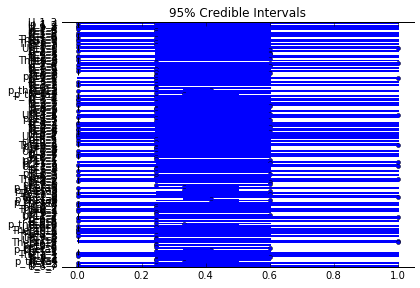

In [60]:
R = raftery_lewis(M, q=0.025, r=0.01)
summary_plot(M)

/home/enguerand/.virtualenvs/gryzz-lab/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


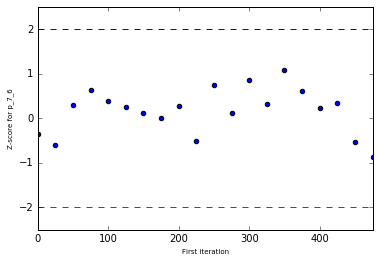

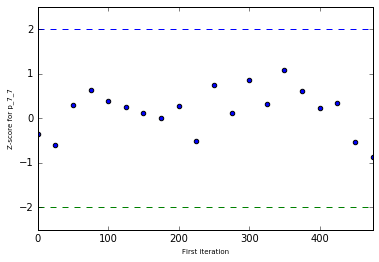

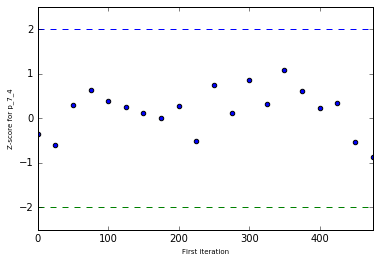

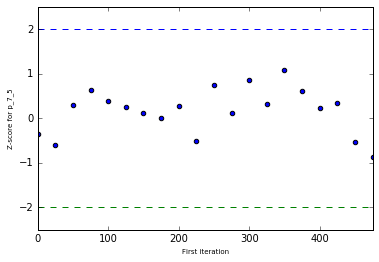

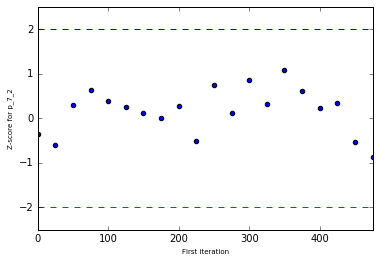

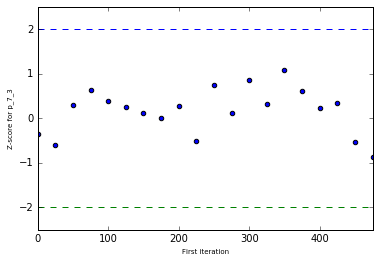

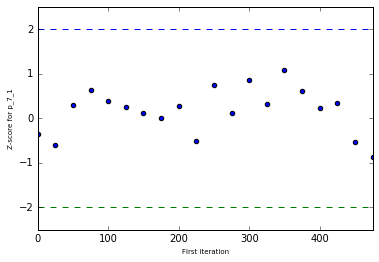

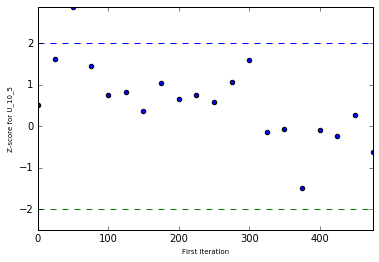

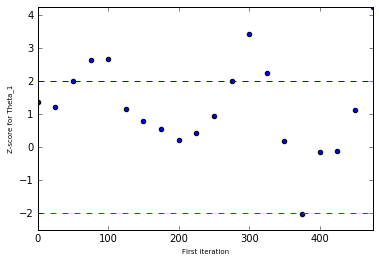

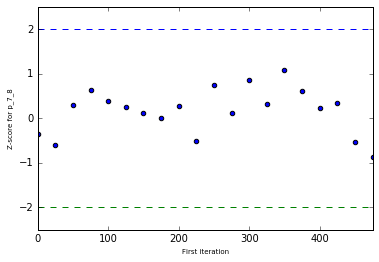

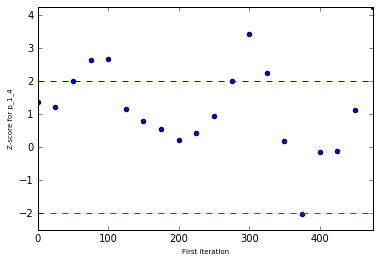

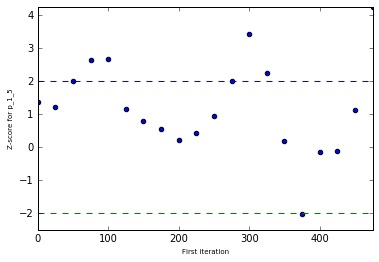

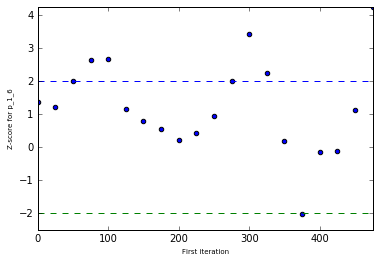

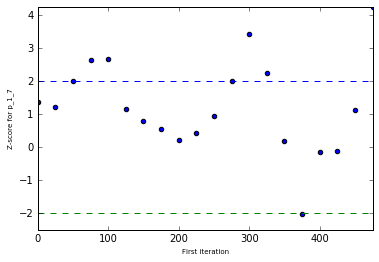

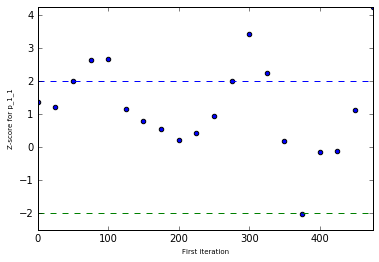

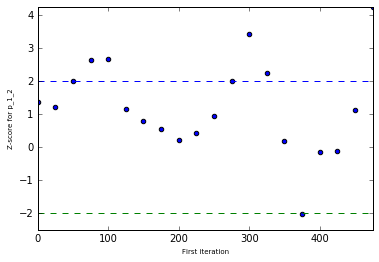

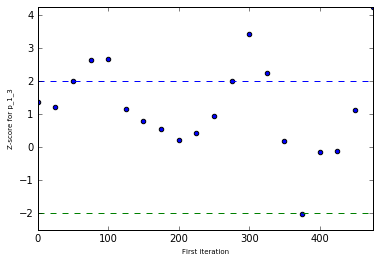

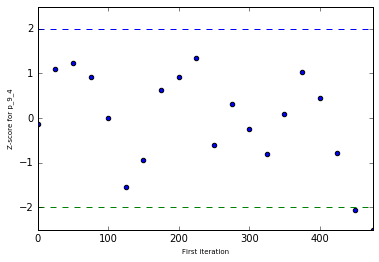

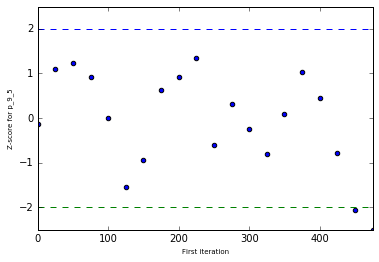

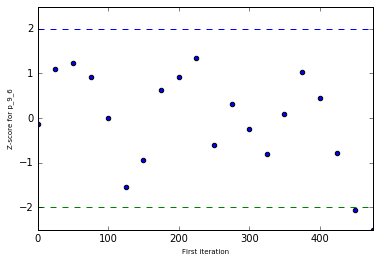

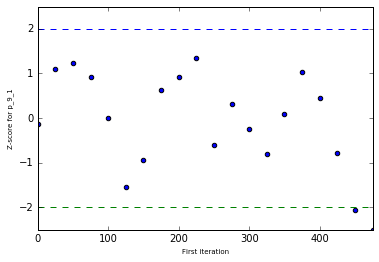

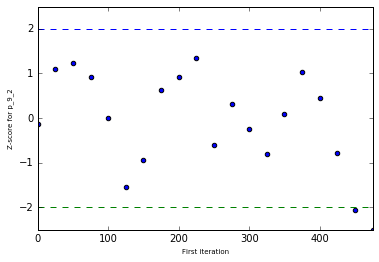

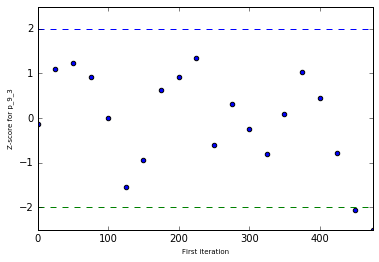

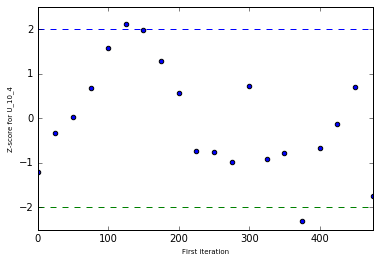

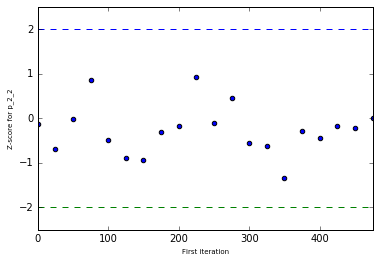

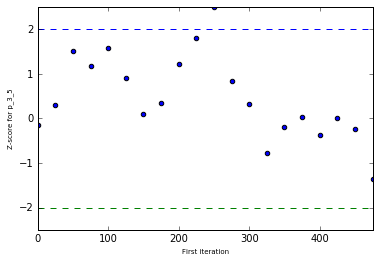

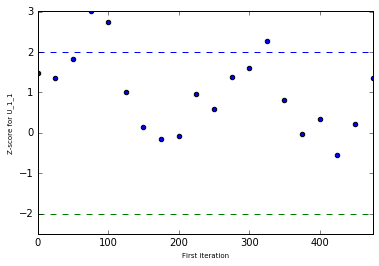

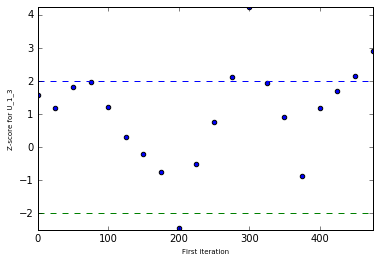

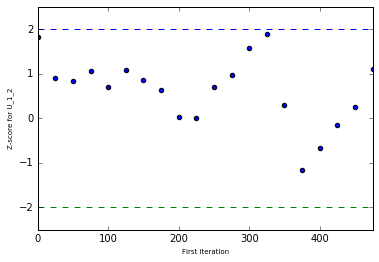

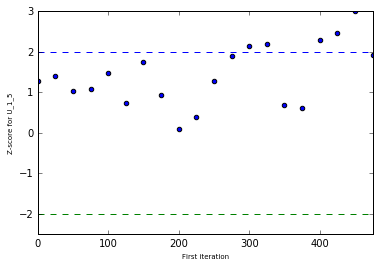

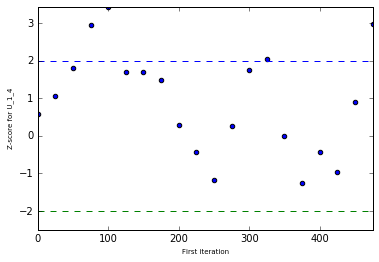

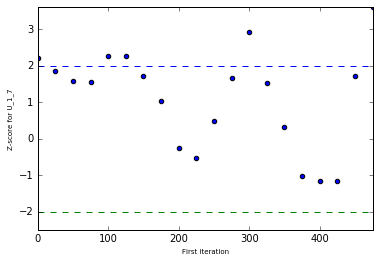

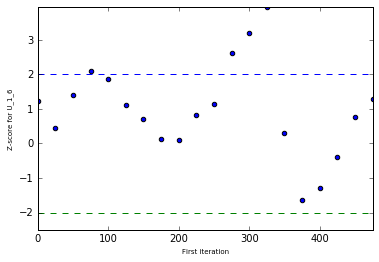

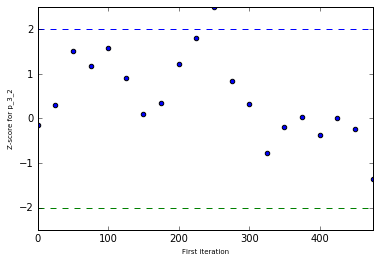

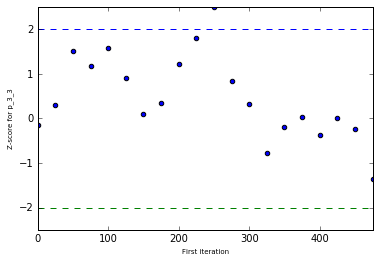

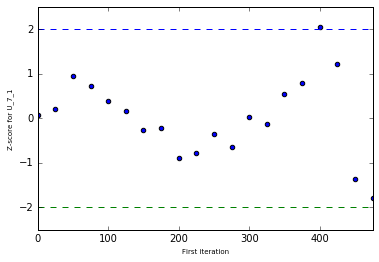

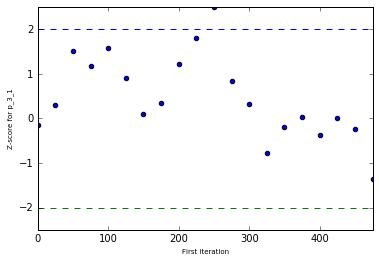

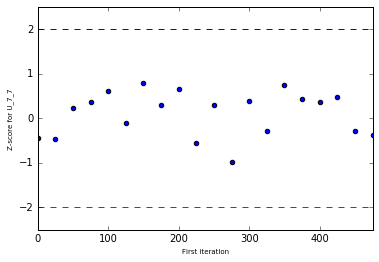

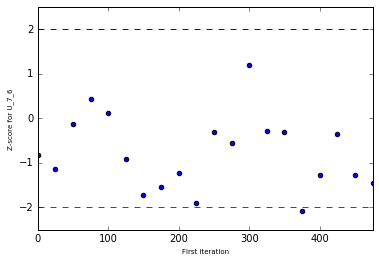

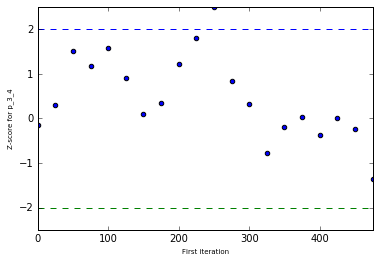

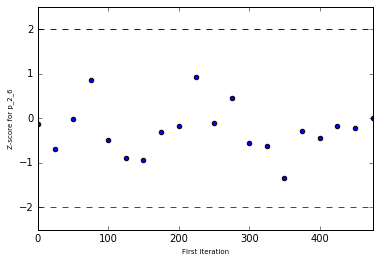

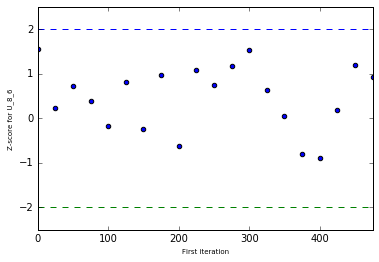

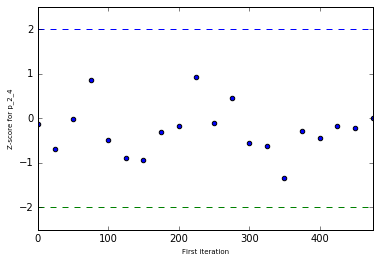

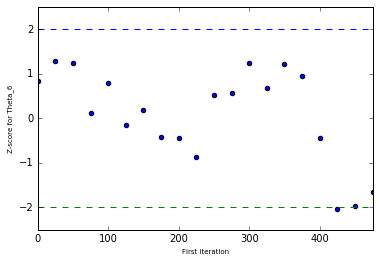

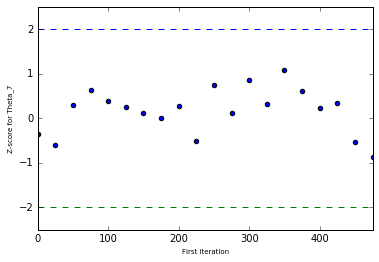

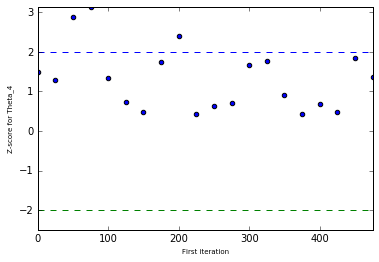

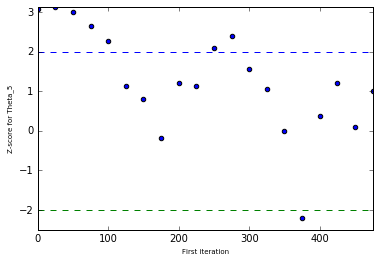

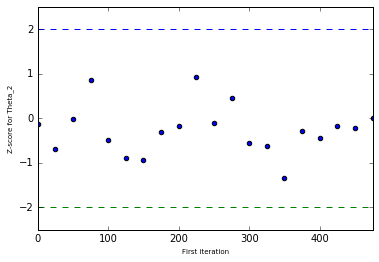

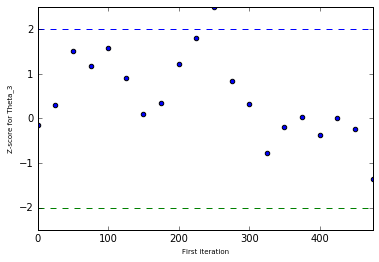

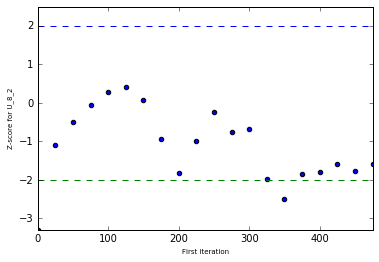

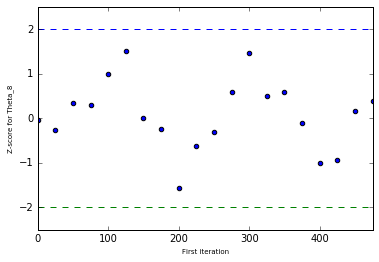

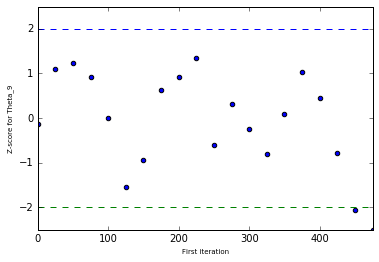

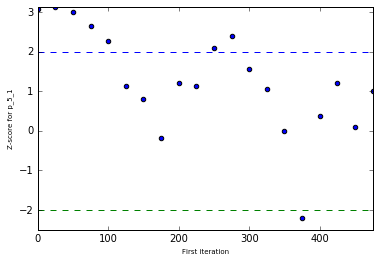

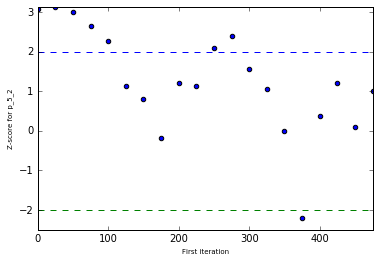

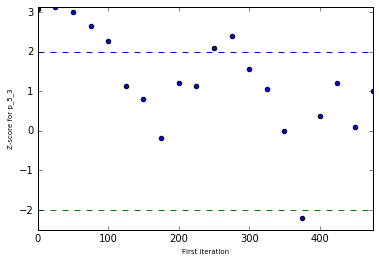

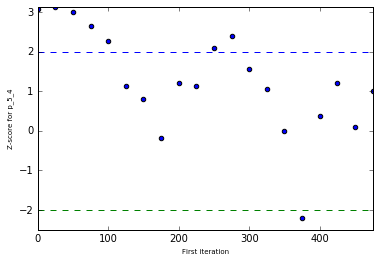

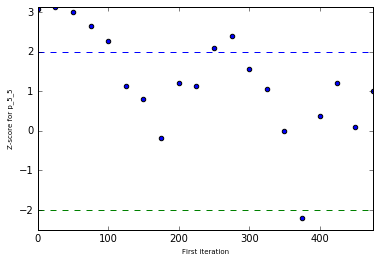

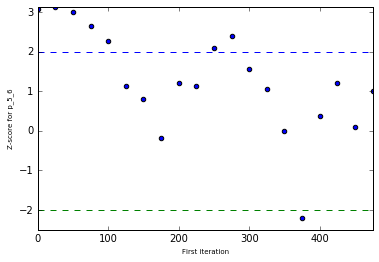

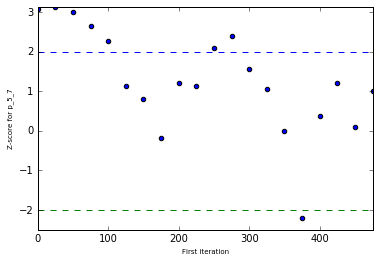

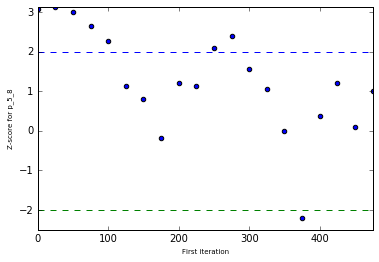

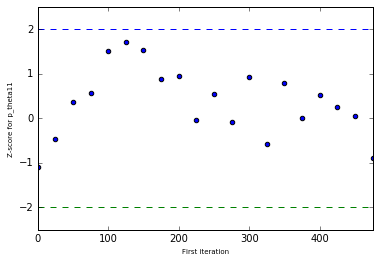

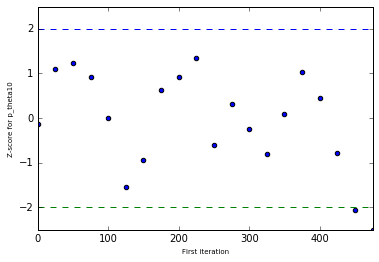

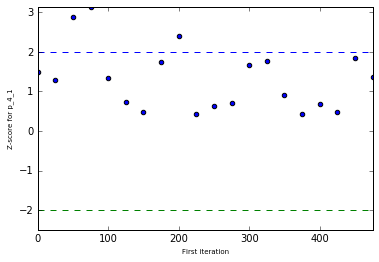

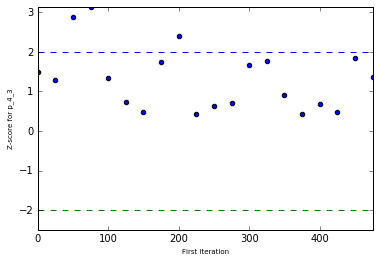

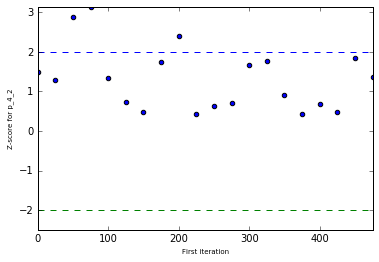

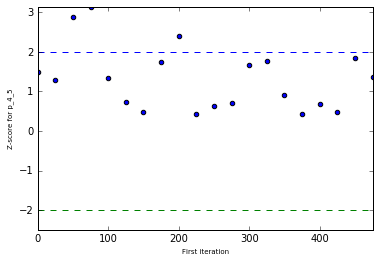

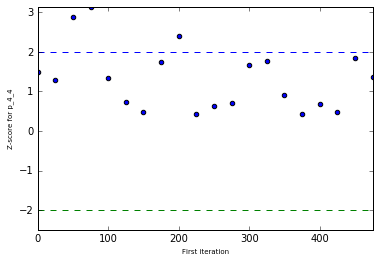

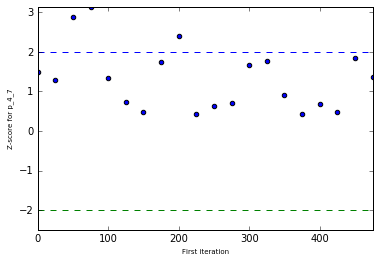

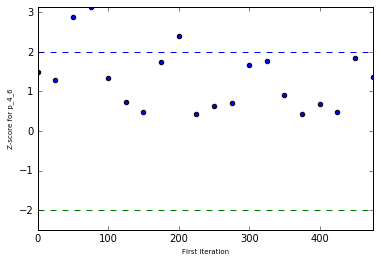

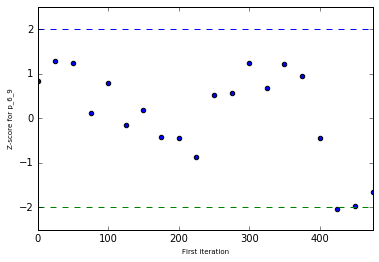

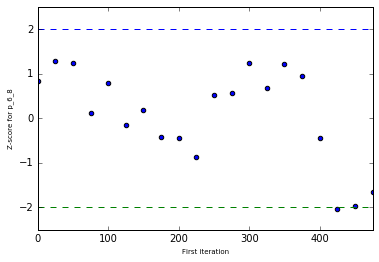

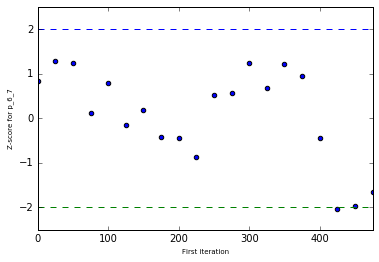

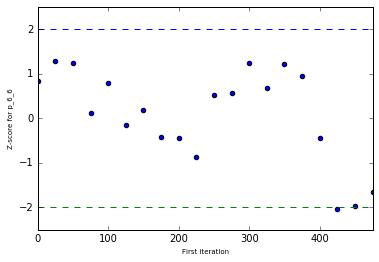

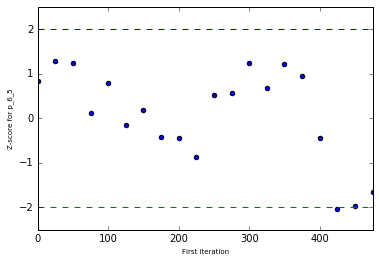

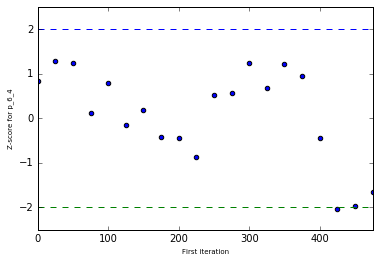

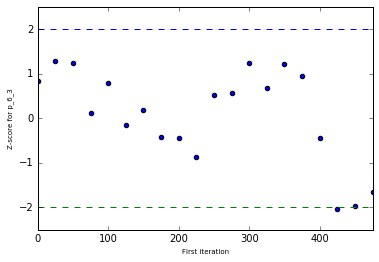

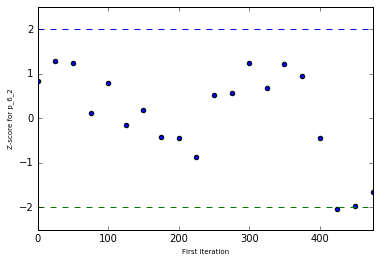

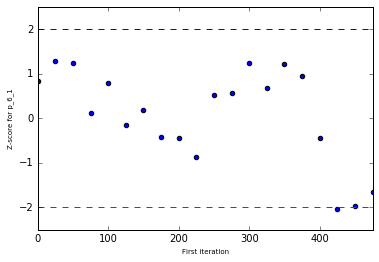

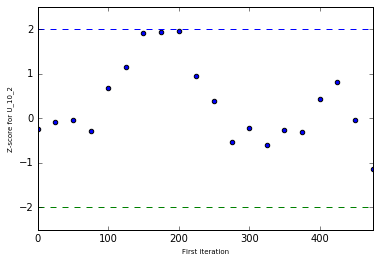

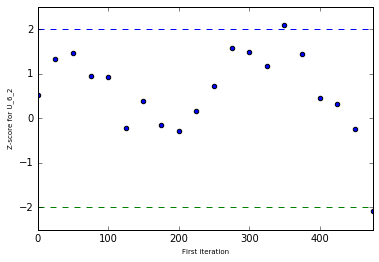

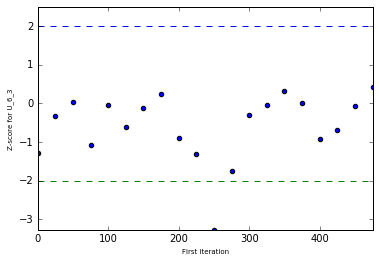

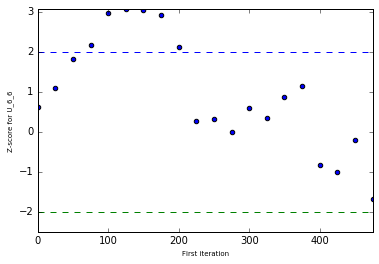

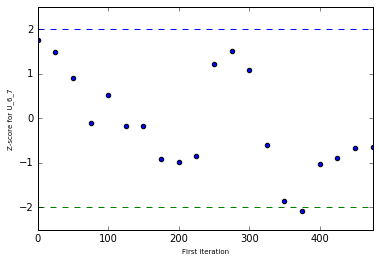

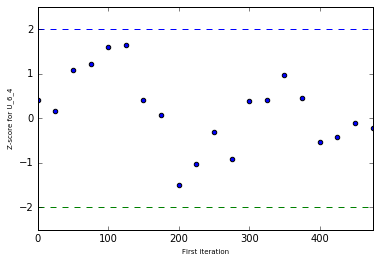

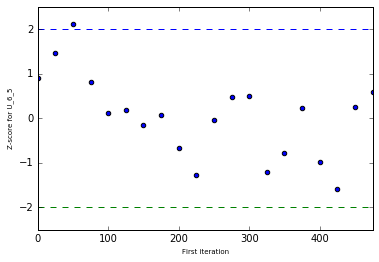

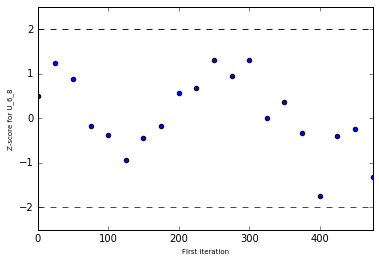

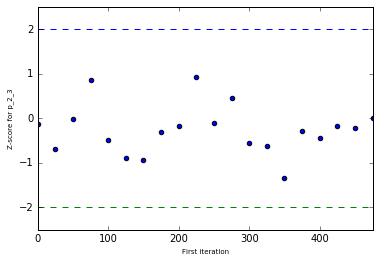

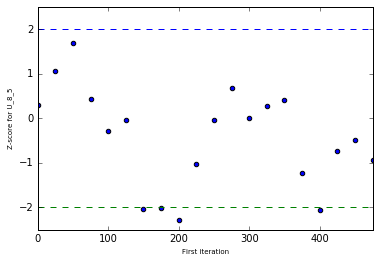

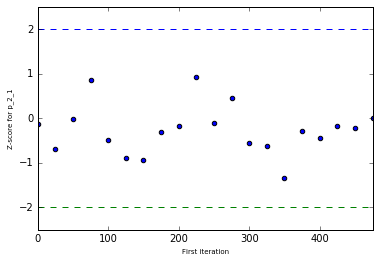

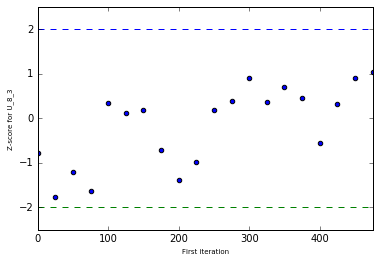

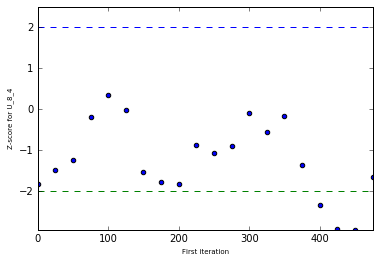

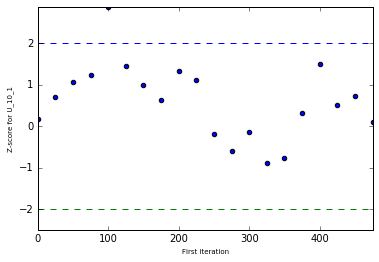

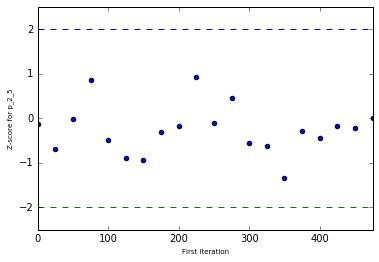

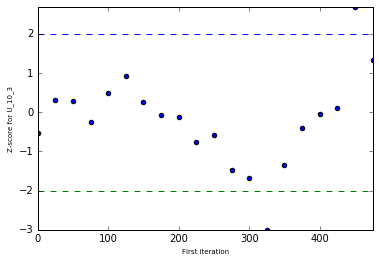

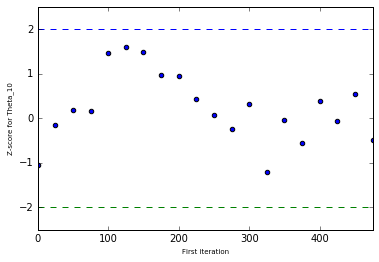

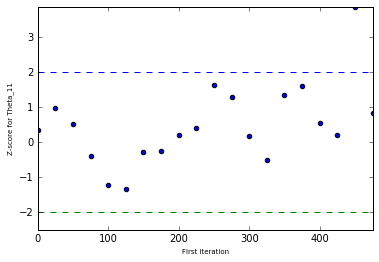

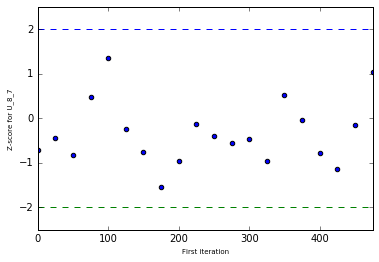

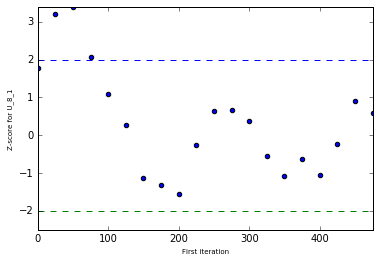

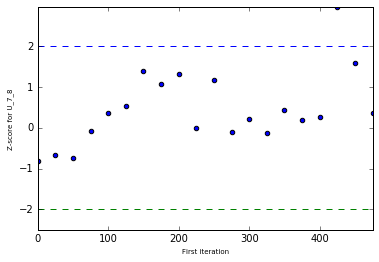

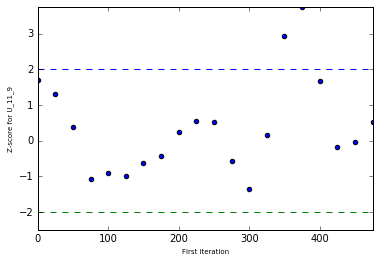

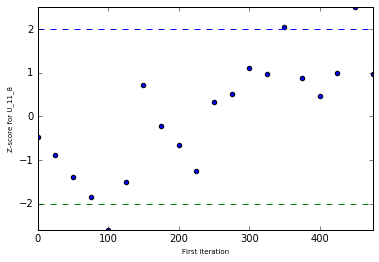

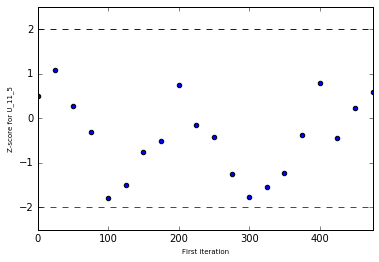

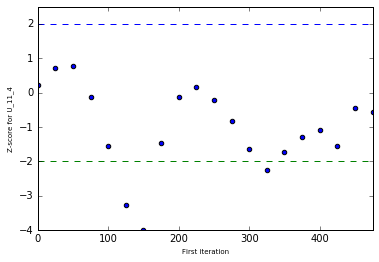

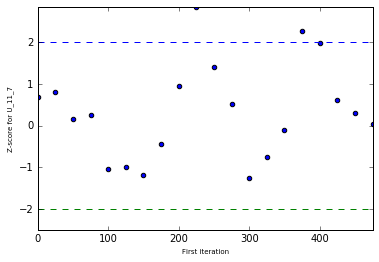

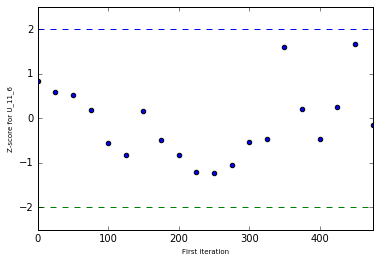

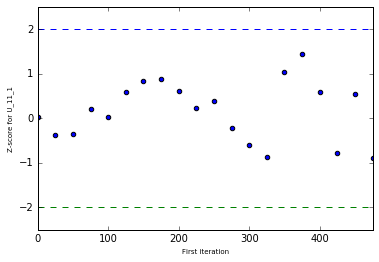

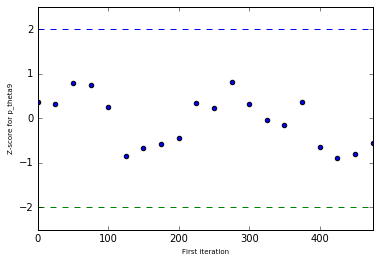

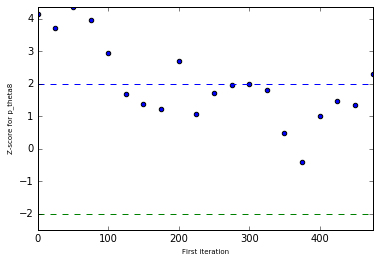

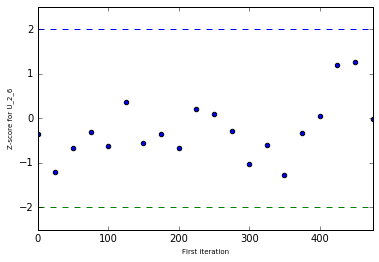

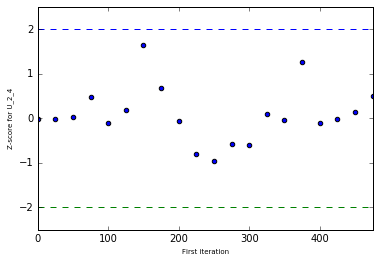

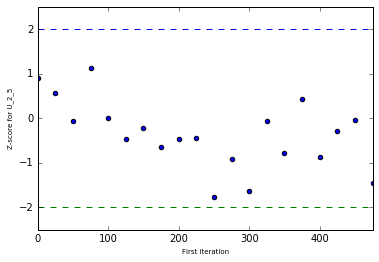

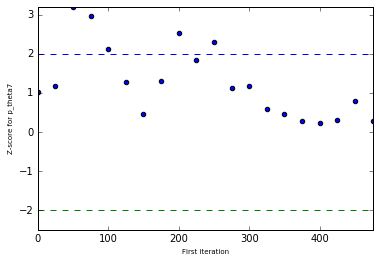

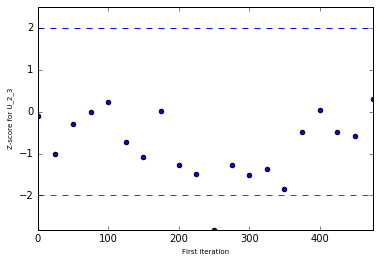

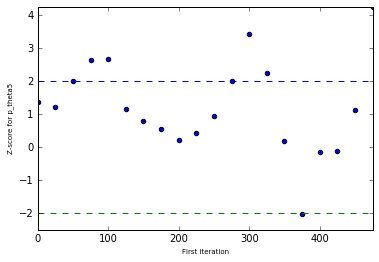

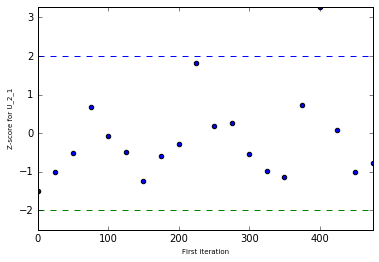

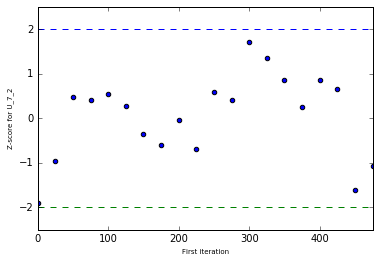

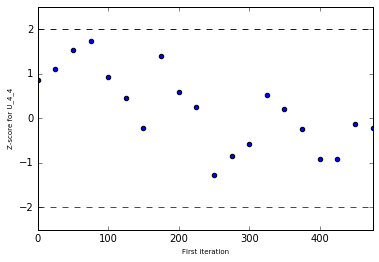

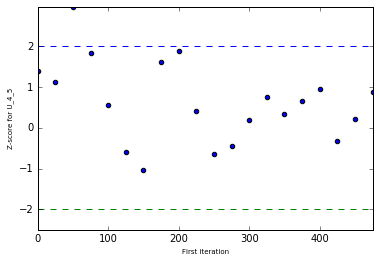

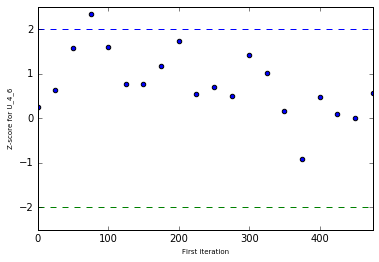

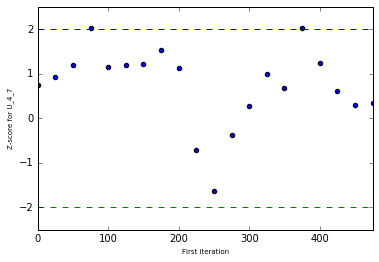

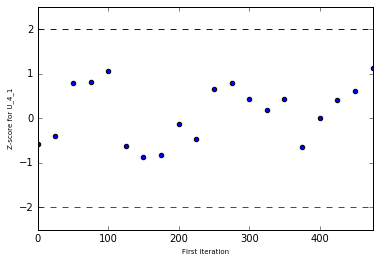

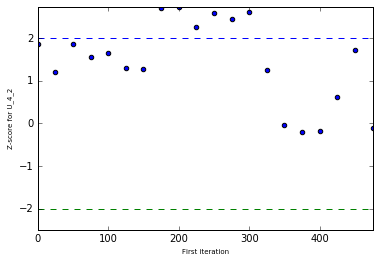

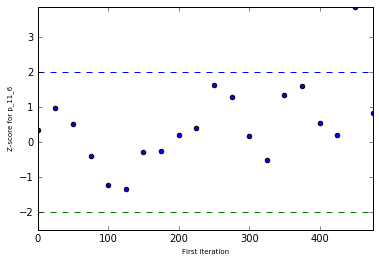

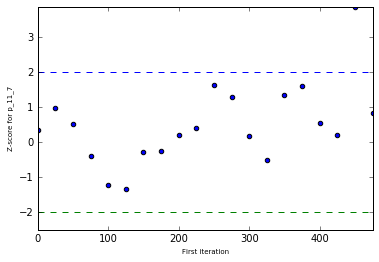

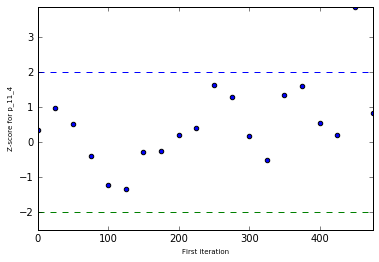

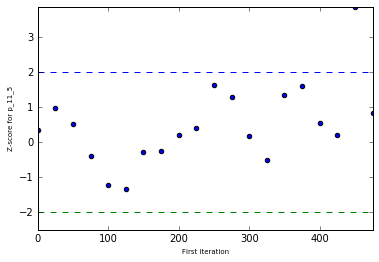

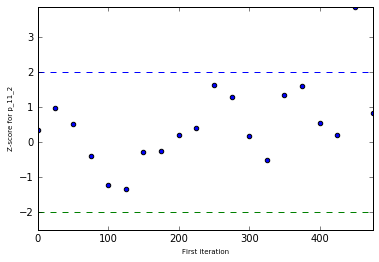

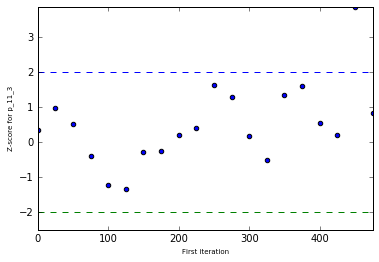

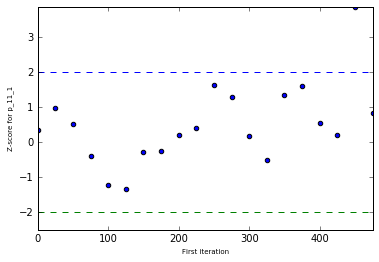

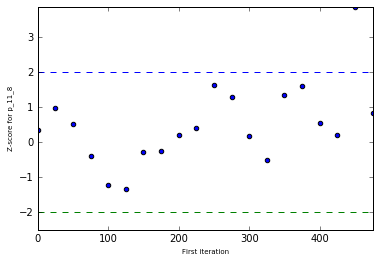

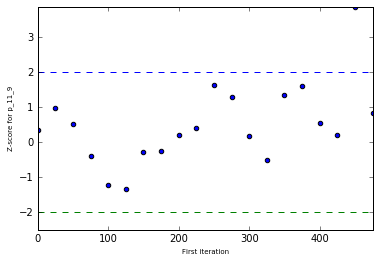

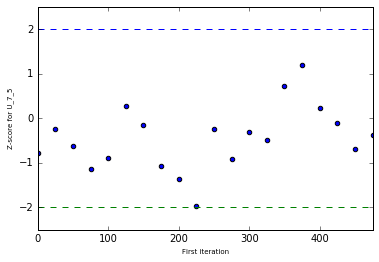

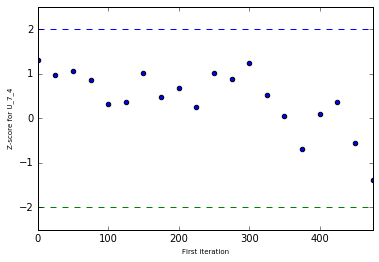

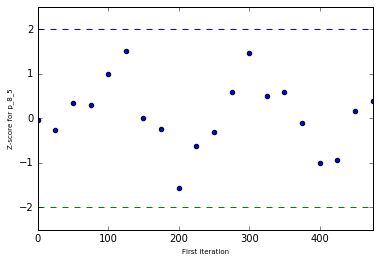

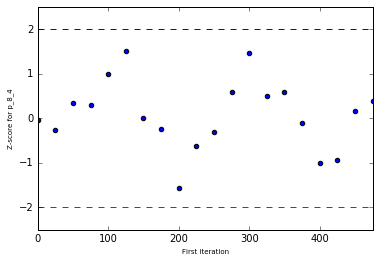

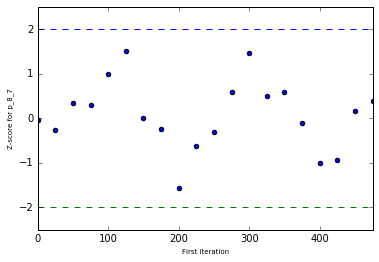

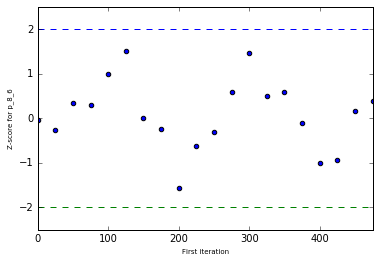

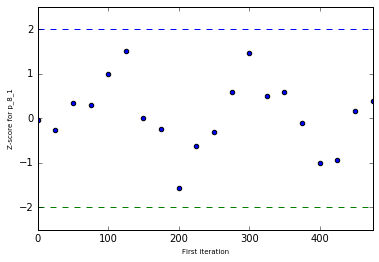

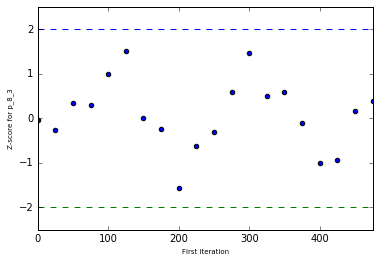

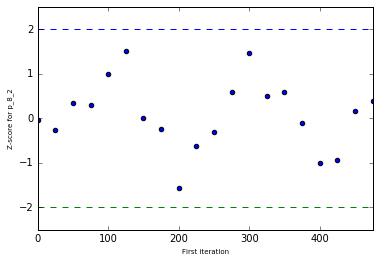

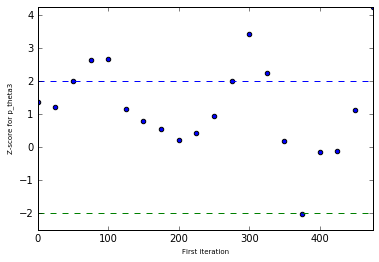

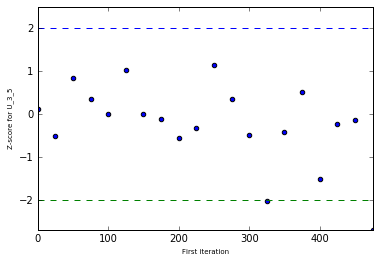

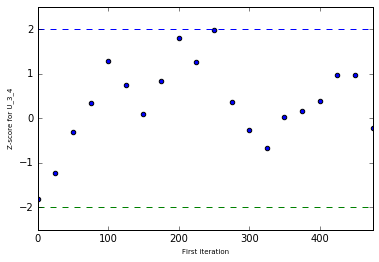

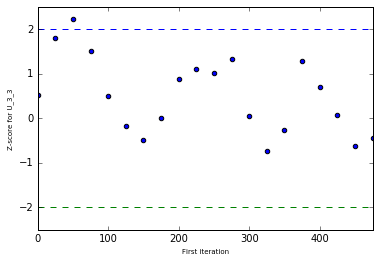

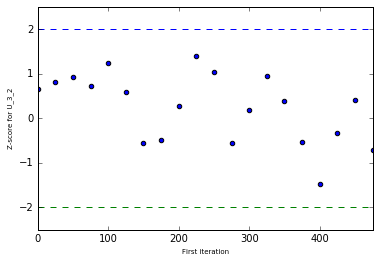

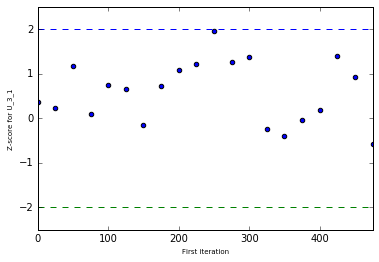

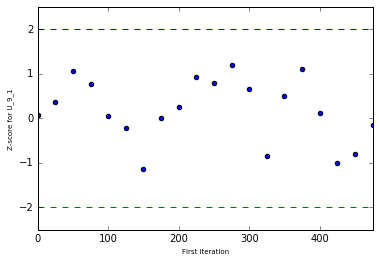

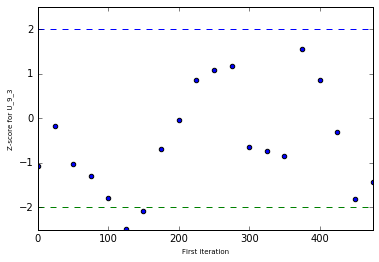

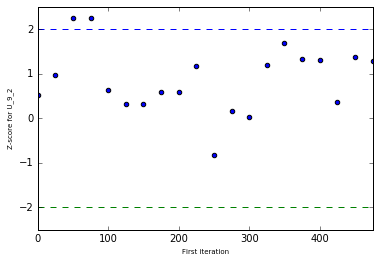

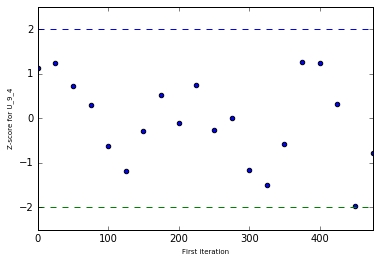

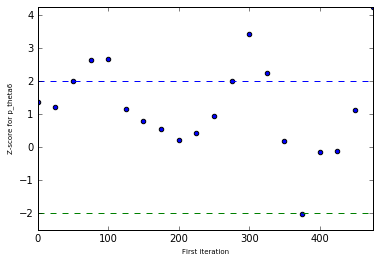

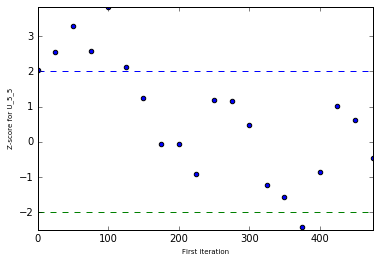

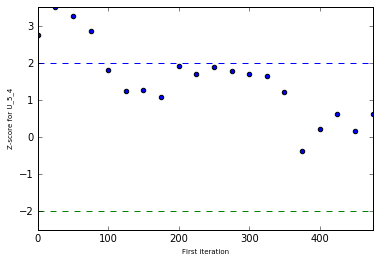

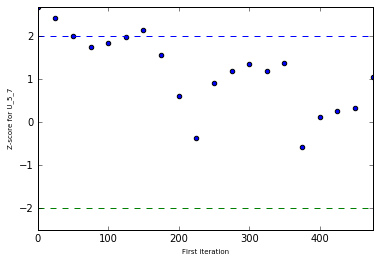

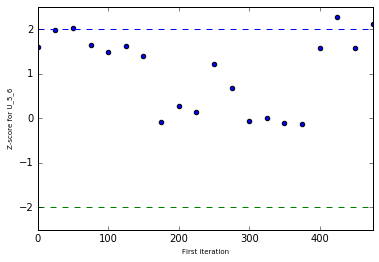

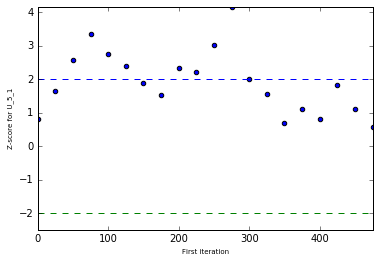

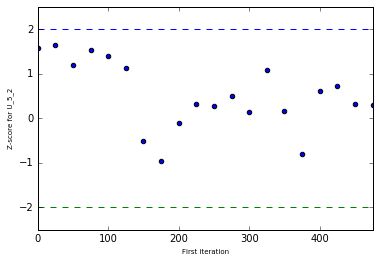

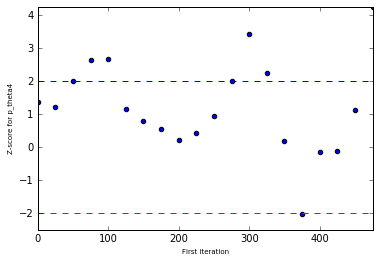

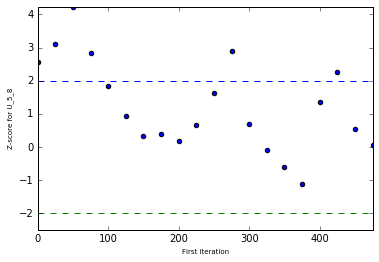

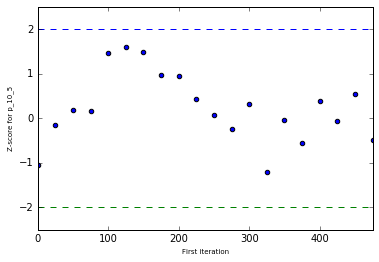

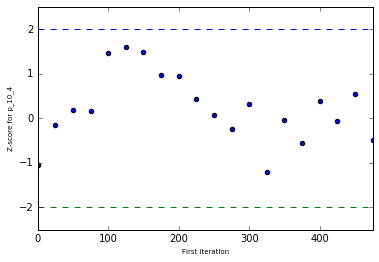

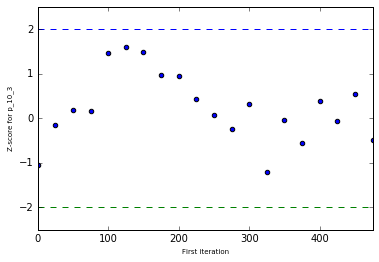

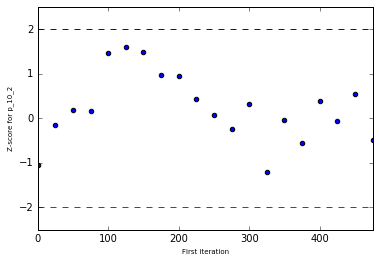

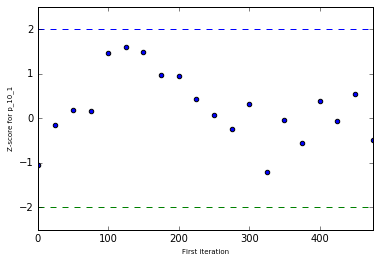

In [59]:
G = geweke(M, intervals=20)
geweke_plot(G)